# **라이브러리 불러오기**

In [62]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [63]:
train=pd.read_csv('../Data/train.csv')
test=pd.read_csv('../Data/test.csv')
submission=pd.read_csv('../Data/sample_submission.csv')

# **[데이터 살펴보기]**

In [127]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

### Numeric, Category 컬럼 분류

In [4]:
numerical_feats = train.dtypes[train.dtypes != 'object'].index.tolist() #인덱스를 리스트로 생성
numerical_feats.remove('credit')
print("Numerical features : ", numerical_feats)

Numerical features :  ['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size', 'begin_month']


In [5]:
categorical_feats = train.dtypes[train.dtypes == 'object'].index.tolist()
print("Categorical features : ", categorical_feats)

Categorical features :  ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


# **[데이터 전처리]**

## Feature 설명

- gender : 성별  (0)
- car : 차량 소유 여부  (0)
- reality : 부동산 소유 여부  (0)
- child_num : 자녀 수   (0)
- income_total : 연간 소득  (o)
- income_type : 소득 분류   
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   (0)
- edu_type : 교육 수준   
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']    (0)
- family_type : 결혼 여부   
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']    (0)
- house_type : 생활 방식   
    ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']    (0)
- DAYS_BIRTH : 출생일   (0)
    => 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
- DAYS_EMPLOYED : 업무 시작일   (0)   
    => 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
- FLAG_MOBIL : 핸드폰 소유 여부  (0) -> drop 
- work_phone : 업무용 전화 소유 여부   (0)
- phone : 전화 소유 여부  (0) 
- email : 이메일 소유 여부   (0)
- occyp_type : 직업 유형	  (0) -> drop 											
- family_size : 가족 규모  (0) 
- begin_month : 신용카드 발급 월 
    => 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
- credit : 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
    => 낮을 수록 높은 신용의 신용카드 사용자를 의미함   

## **1. occyp_type, index, FLAG_MOBILE drop**
- FLAG_MOBILE : 모두 1값을 갖기때문에 의미 없음
- occyp_type : null 값

In [64]:
train.drop('occyp_type', axis=1, inplace=True)
test.drop('occyp_type', axis=1, inplace=True)

In [65]:
train.drop('FLAG_MOBIL', axis=1, inplace=True)
test.drop('FLAG_MOBIL', axis=1, inplace=True)

In [66]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

## **2. numeric -> categorical 변환**
- catboost를 돌리기 위한 categorical한 변수생성
    - child_num, family_size 
    - begin_month, DAYS_EMOPYED, DAYS_BIRTH, income_total : 이상치제거
    - work_phone, phone, email

### child_num

In [67]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [68]:
train.loc[train['child_num']>=3,'child_num'] = 3
test.loc[test['child_num']>=3, 'child_num'] = 3

In [69]:
train['child_num'].value_counts()

0    18340
1     5386
2     2362
3      369
Name: child_num, dtype: int64

In [70]:
test['child_num'] = test['child_num'].astype('object')
train['child_num'] = train['child_num'].astype('object')

In [71]:
train['child_num'].value_counts()

0    18340
1     5386
2     2362
3      369
Name: child_num, dtype: int64

In [72]:
test['child_num'].value_counts()

0    6861
1    2106
2     894
3     139
Name: child_num, dtype: int64

### family_size

In [73]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [74]:
train.loc[train['family_size']>=5, 'family_size'] = 5
test.loc[test['family_size']>=5, 'family_size'] = 5

In [75]:
train['family_size'].value_counts()
#test['family_size'].value_counts()

2.0    14106
1.0     5109
3.0     4632
4.0     2260
5.0      350
Name: family_size, dtype: int64

In [76]:
test['family_size'] = test['family_size'].astype('object')
train['family_size'] = train['family_size'].astype('object')

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  object 
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  family_size    26457 non-null  object 
 15  begin_month    26457 non-null  float64
 16  credit         26457 non-null  float64
dtypes: float64(3), int64(5), object(9)
memory usage: 3

In [78]:
'''Q1 = train['family_size'].quantile(.25)
Q3 = train['family_size'].quantile(.75)
IQR = Q3 - Q1
Q2 = train['family_size'].quantile(.5)
Q4 = train['family_size'].quantile(1)


train.loc[train['family_size'] <= Q1,'child_num'] = 1
train.loc[(train['family_size'] > Q1) & (train['family_size'] <= Q2),'child_num'] = 2
train.loc[(train['family_size'] > Q2) & (train['family_size'] <= Q3),'child_num'] = 3
train.loc[(train['family_size'] > Q3) & (train['family_size'] <= Q4),'child_num'] = 4
train.loc[train['family_size'] != Q4, 'child_num'] = 5

test.loc[test['family_size'] <= Q1,'child_num'] = 1
test.loc[(test['family_size'] > Q1) & (test['family_size'] <= Q2),'child_num'] = 2
test.loc[(test['family_size'] > Q2) & (test['family_size'] <= Q3),'child_num'] = 3
test.loc[(test['family_size'] > Q3) & (test['family_size'] <= Q4),'child_num'] = 4
test.loc[test['family_size'] != Q4, 'child_num'] = 5

test['family_size'] = test['family_size'].replace([1,2,3,4,5],['A','B','C','D','E'])
train['family_size'] = train['family_size'].replace([1,2,3,4,5],['A','B','C','D','E'])

train['family_size'].value_counts()
test['family_size'].value_counts()'''

"Q1 = train['family_size'].quantile(.25)\nQ3 = train['family_size'].quantile(.75)\nIQR = Q3 - Q1\nQ2 = train['family_size'].quantile(.5)\nQ4 = train['family_size'].quantile(1)\n\n\ntrain.loc[train['family_size'] <= Q1,'child_num'] = 1\ntrain.loc[(train['family_size'] > Q1) & (train['family_size'] <= Q2),'child_num'] = 2\ntrain.loc[(train['family_size'] > Q2) & (train['family_size'] <= Q3),'child_num'] = 3\ntrain.loc[(train['family_size'] > Q3) & (train['family_size'] <= Q4),'child_num'] = 4\ntrain.loc[train['family_size'] != Q4, 'child_num'] = 5\n\ntest.loc[test['family_size'] <= Q1,'child_num'] = 1\ntest.loc[(test['family_size'] > Q1) & (test['family_size'] <= Q2),'child_num'] = 2\ntest.loc[(test['family_size'] > Q2) & (test['family_size'] <= Q3),'child_num'] = 3\ntest.loc[(test['family_size'] > Q3) & (test['family_size'] <= Q4),'child_num'] = 4\ntest.loc[test['family_size'] != Q4, 'child_num'] = 5\n\ntest['family_size'] = test['family_size'].replace([1,2,3,4,5],['A','B','C','D','E'])

### begin_month

<AxesSubplot:ylabel='Frequency'>

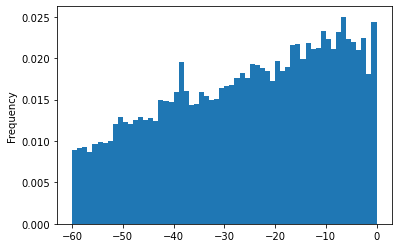

In [79]:
train['begin_month'].value_counts()
train['begin_month'].plot(kind='hist',bins=60,density=True)

<AxesSubplot:ylabel='Frequency'>

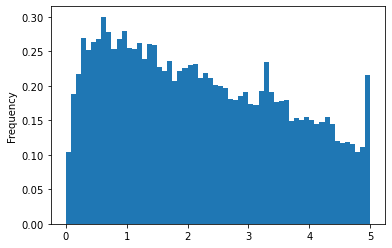

In [80]:
train['begin_month'] = abs(train['begin_month']/12) # 년단위로 묶음
test['begin_month'] = abs(test['begin_month']/12)

train['begin_month'].plot(kind='hist',bins=60,density=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e48cd1c970>,
 'caps': [<matplotlib.lines.Line2D at 0x1e48cd2b070>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e48cd1c610>],
 'medians': [<matplotlib.lines.Line2D at 0x1e48cd2b730>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e48cd2ba90>],
 'means': []}

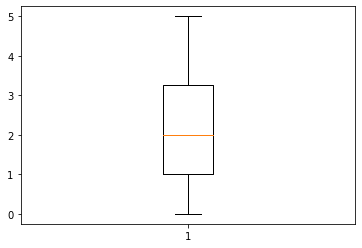

In [81]:
plt.boxplot(train['begin_month'])

In [82]:
# 년단위로 범주화 
train_and_test = [train, test]
for dataset in train_and_test :
    Q1 = dataset['begin_month'].quantile(.25)
    Q3 = dataset['begin_month'].quantile(.75)
    IQR = Q3 - Q1
    Q2 = dataset['begin_month'].quantile(.5)
    Q4 = dataset['begin_month'].quantile(1)
    #print(Q1, Q2, Q3, Q4)

train.loc[train['begin_month'] <= Q1,'begin_month'] = 1
train.loc[(train['begin_month'] > Q1) & (train['begin_month'] <= Q2),'begin_month'] = 2
train.loc[(train['begin_month'] > Q2) & (train['begin_month'] <= Q3),'begin_month'] = 3
train.loc[(train['begin_month'] > Q3) & (train['begin_month'] <= Q4),'begin_month'] = 4

test.loc[test['begin_month'] <= Q1,'begin_month'] = 1
test.loc[(test['begin_month'] > Q1) & (test['begin_month'] <= Q2),'begin_month'] = 2
test.loc[(test['begin_month'] > Q2) & (test['begin_month'] <= Q3),'begin_month'] = 3
test.loc[(test['begin_month'] > Q3) & (test['begin_month'] <= Q4),'begin_month'] = 4

train['begin_month'] = train['begin_month'].replace([1,2,3,4],['A','B','C','D'])
test['begin_month'] = test['begin_month'].replace([1,2,3,4],['A','B','C','D'])

In [83]:
train['begin_month'].value_counts()

A    7049
B    6781
D    6566
C    6061
Name: begin_month, dtype: int64

In [84]:
test['begin_month'].value_counts()

B    2633
A    2541
D    2458
C    2368
Name: begin_month, dtype: int64

In [85]:
''' for i in range(0, 5, 1):
    start = i 
    end = i + 1
    temp = train[(train['begin_month'] >= start) & (train['begin_month'] < end)]
    print("{}년 이상 {}년 미만 : {}".format(start, end, temp['begin_month'].count()))'''

' for i in range(0, 5, 1):\n    start = i \n    end = i + 1\n    temp = train[(train[\'begin_month\'] >= start) & (train[\'begin_month\'] < end)]\n    print("{}년 이상 {}년 미만 : {}".format(start, end, temp[\'begin_month\'].count()))'

### DAYS_EMPLOYED

In [86]:
train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

In [87]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])

In [88]:
train['DAYS_EMPLOYED'].value_counts()

0       4438
401       57
1539      47
200       45
2087      44
        ... 
7864       1
1723       1
1755       1
5865       1
4305       1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

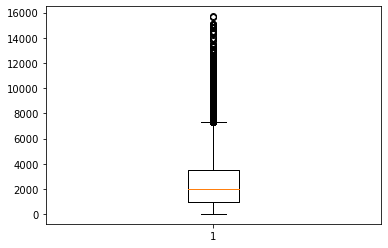

In [89]:
plt.boxplot(train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'])
plt.show()

In [90]:
train_and_test = [train, test]
for dataset in train_and_test :
    Q1 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(0.25)
    Q2 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(0.5)
    Q3 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(0.75)
    Q4 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(1.0)
    IQR = Q3 - Q1
    
train.loc[train['DAYS_EMPLOYED'] == 0 ,'DAYS_EMPLOYED'] = 0
train.loc[(train['DAYS_EMPLOYED'] != 0) & (train['DAYS_EMPLOYED'] <= Q1),'DAYS_EMPLOYED'] = 1
train.loc[(train['DAYS_EMPLOYED'] > Q1) & (train['DAYS_EMPLOYED'] <= Q2),'DAYS_EMPLOYED'] = 2
train.loc[(train['DAYS_EMPLOYED'] > Q2) & (train['DAYS_EMPLOYED'] <= Q3),'DAYS_EMPLOYED'] = 3
train.loc[(train['DAYS_EMPLOYED'] > Q3) & (train['DAYS_EMPLOYED'] <= Q4),'DAYS_EMPLOYED'] = 4

test.loc[test['DAYS_EMPLOYED'] == 0 ,'DAYS_EMPLOYED'] = 0
test.loc[(test['DAYS_EMPLOYED'] != 0) & (test['DAYS_EMPLOYED'] <= Q1),'DAYS_EMPLOYED'] = 1
test.loc[(test['DAYS_EMPLOYED'] > Q1) & (test['DAYS_EMPLOYED'] <= Q2),'DAYS_EMPLOYED'] = 2
test.loc[(test['DAYS_EMPLOYED'] > Q2) & (test['DAYS_EMPLOYED'] <= Q3),'DAYS_EMPLOYED'] = 3
test.loc[(test['DAYS_EMPLOYED'] > Q3) & (test['DAYS_EMPLOYED'] <= Q4),'DAYS_EMPLOYED'] = 4

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace([0,1,2,3,4],['A','B','C','D','E'])
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace([0,1,2,3,4],['A','B','C','D','E'])


In [91]:
train['DAYS_EMPLOYED'].value_counts()

D    5511
C    5506
B    5505
E    5497
A    4438
Name: DAYS_EMPLOYED, dtype: int64

In [92]:
test['DAYS_EMPLOYED'].value_counts()

D    2160
E    2060
C    2054
B    2029
A    1697
Name: DAYS_EMPLOYED, dtype: int64

### DAYS_BIRTH

<AxesSubplot:ylabel='Frequency'>

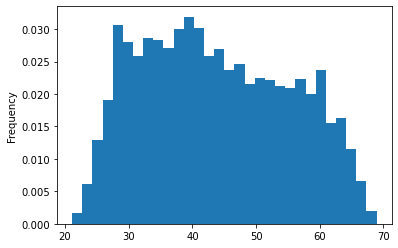

In [93]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH']/365)
test['DAYS_BIRTH'] = abs(test['DAYS_BIRTH']/365)

train['DAYS_BIRTH'].plot(kind='hist',bins=30,density=True)

In [94]:
# 20세 이상만 존재 

{'whiskers': [<matplotlib.lines.Line2D at 0x1e48a68df10>,
 'caps': [<matplotlib.lines.Line2D at 0x1e48a69e610>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e48a68dbb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e48a69ec70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e48a69efd0>],
 'means': []}

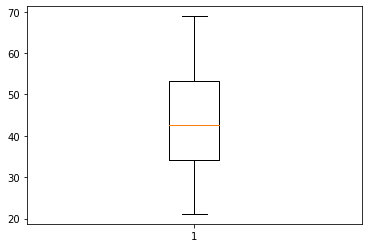

In [95]:
plt.boxplot(train['DAYS_BIRTH'])

In [96]:
train_and_test = [train, test]
for dataset in train_and_test :
    Q1 = train['DAYS_BIRTH'].quantile(.25)
    Q3 = train['DAYS_BIRTH'].quantile(.75)
    IQR = Q3 - Q1
    Q2 = train['DAYS_BIRTH'].quantile(.5)
    Q4 = train['DAYS_BIRTH'].quantile(1)


train.loc[train['DAYS_BIRTH'] <= Q1,'DAYS_BIRTH'] = 1
train.loc[(train['DAYS_BIRTH'] > Q1) & (train['DAYS_BIRTH'] <= Q2),'DAYS_BIRTH'] = 2
train.loc[(train['DAYS_BIRTH'] > Q2) & (train['DAYS_BIRTH'] <= Q3),'DAYS_BIRTH'] = 3
train.loc[(train['DAYS_BIRTH'] > Q3) & (train['DAYS_BIRTH'] <= Q4),'DAYS_BIRTH'] = 4

test.loc[test['DAYS_BIRTH'] <= Q1,'DAYS_BIRTH'] = 1
test.loc[(test['DAYS_BIRTH'] > Q1) & (test['DAYS_BIRTH'] <= Q2),'DAYS_BIRTH'] = 2
test.loc[(test['DAYS_BIRTH'] > Q2) & (test['DAYS_BIRTH'] <= Q3),'DAYS_BIRTH'] = 3
test.loc[(test['DAYS_BIRTH'] > Q3) & (test['DAYS_BIRTH'] <= Q4),'DAYS_BIRTH'] = 4

test['DAYS_BIRTH'] = test['DAYS_BIRTH'].replace([1,2,3,4],['A','B','C','D'])
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].replace([1,2,3,4],['A','B','C','D'])

In [97]:
train['DAYS_BIRTH'].value_counts()

C    6626
A    6616
B    6613
D    6602
Name: DAYS_BIRTH, dtype: int64

In [98]:
test['DAYS_BIRTH'].value_counts()

C    2528
D    2525
B    2499
A    2448
Name: DAYS_BIRTH, dtype: int64

### income_total

In [99]:
train['income_total'].value_counts()

135000.0    3164
157500.0    2233
180000.0    2225
112500.0    2178
225000.0    2170
            ... 
227250.0       1
91530.0        1
39600.0        1
432000.0       1
215100.0       1
Name: income_total, Length: 249, dtype: int64

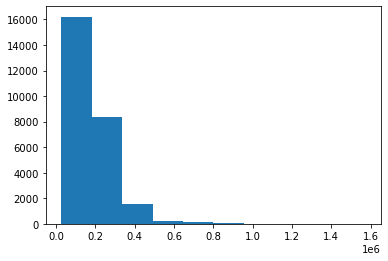

In [100]:
plt.hist(train['income_total'])
plt.show()

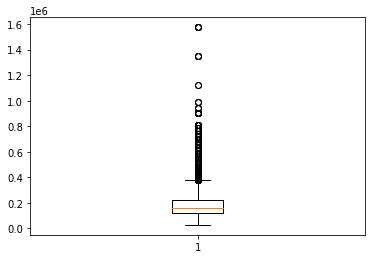

In [101]:
plt.boxplot(train['income_total'])

plt.show()

In [102]:
train_and_test = [train, test]
for dataset in train_and_test :
    Q1 = train['income_total'].quantile(.25)
    Q3 = train['income_total'].quantile(.75)
    IQR = Q3 - Q1
    Q2 = train['income_total'].quantile(.5)
    Q4 = train['income_total'].quantile(1)


train.loc[train['income_total'] <= Q1,'income_total'] = 1
train.loc[(train['income_total'] > Q1) & (train['income_total'] <= Q2),'income_total'] = 2
train.loc[(train['income_total'] > Q2) & (train['income_total'] <= Q3),'income_total'] = 3
train.loc[(train['income_total'] > Q3) & (train['income_total'] <= Q4),'income_total'] = 4

test.loc[test['income_total'] <= Q1,'income_total'] = 1
test.loc[(test['income_total'] > Q1) & (test['income_total'] <= Q2),'income_total'] = 2
test.loc[(test['income_total'] > Q2) & (test['income_total'] <= Q3),'income_total'] = 3
test.loc[(test['income_total'] > Q3) & (test['income_total'] <= Q4),'income_total'] = 4


test['income_total'] = test['income_total'].replace([1,2,3,4],['A','B','C','D'])
train['income_total'] = train['income_total'].replace([1,2,3,4],['A','B','C','D'])

In [103]:
train['income_total'].value_counts()

C    7334
A    6751
B    6685
D    5687
Name: income_total, dtype: int64

In [104]:
test['income_total'].value_counts()

C    2791
A    2642
B    2485
D    2082
Name: income_total, dtype: int64

### work_phone, phone

In [105]:
train['work_phone'].value_counts()
test['work_phone'].value_counts()

0    7724
1    2276
Name: work_phone, dtype: int64

In [106]:
train['work_phone'] = train['work_phone'].replace([0,1],['Y','N'])
test['work_phone'] = test['work_phone'].replace([0,1],['Y','N'])

In [107]:
train['phone'].value_counts()
test['phone'].value_counts()

0    7037
1    2963
Name: phone, dtype: int64

In [108]:
train['phone'] = train['phone'].replace([0,1],['Y','N'])
test['phone'] = test['phone'].replace([0,1],['Y','N'])

### email 

In [109]:
train['email'].value_counts()

0    24042
1     2415
Name: email, dtype: int64

In [110]:
train['email'] = train['email'].replace([0,1],['Y','N'])
test['email'] = test['email'].replace([0,1],['Y','N'])

## 확인

In [50]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,0,C,Commercial associate,Higher education,Married,Municipal apartment,B,E,Y,Y,Y,2.0,A,1.0
1,F,N,Y,1,D,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,A,C,Y,Y,N,3.0,A,1.0
2,M,Y,Y,0,D,Working,Higher education,Married,House / apartment,C,E,Y,N,Y,2.0,B,2.0
3,F,N,Y,0,C,Commercial associate,Secondary / secondary special,Married,House / apartment,B,D,Y,N,Y,2.0,C,0.0
4,F,Y,Y,0,B,State servant,Higher education,Married,House / apartment,B,D,Y,Y,Y,2.0,C,2.0


In [51]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,M,Y,N,0,A,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,D,A,Y,N,Y,2.0,D
1,F,N,Y,0,B,State servant,Higher education,Married,House / apartment,C,E,Y,N,Y,2.0,C
2,F,N,Y,0,A,Working,Secondary / secondary special,Married,House / apartment,C,B,N,N,Y,2.0,D
3,M,Y,N,0,A,Commercial associate,Secondary / secondary special,Married,House / apartment,C,D,N,Y,Y,2.0,D
4,F,Y,Y,0,C,State servant,Higher education,Married,House / apartment,C,E,N,Y,Y,2.0,A


In [52]:
train.shape

(26457, 17)

In [53]:
test.shape

(10000, 16)

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  object 
 4   income_total   26457 non-null  object 
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  object 
 10  DAYS_EMPLOYED  26457 non-null  object 
 11  work_phone     26457 non-null  object 
 12  phone          26457 non-null  object 
 13  email          26457 non-null  object 
 14  family_size    26457 non-null  object 
 15  begin_month    26457 non-null  object 
 16  credit         26457 non-null  float64
dtypes: float64(1), object(16)
memory usage: 3.4+ MB


# **[데이터 모델링]**

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

In [112]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [113]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 16) (26457, 1) (10000, 16)


### 1. Random Forest

In [52]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
clf=RandomForestClassifier(n_estimators = 400, max_depth = 10, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.662
테스트 세트 정확도: 0.642
log_loss: 0.848991218301675


In [57]:
print("특성 중요도:\n{}".format(clf.feature_importances_))

특성 중요도:
[0.20641654 0.03045403 0.0326307  0.02908583 0.02735945 0.03515414
 0.04334575 0.04458918 0.050692   0.04602408 0.09457275 0.01158531
 0.         0.02788728 0.03052253 0.02190098 0.04722298 0.22055646]


<AxesSubplot:>

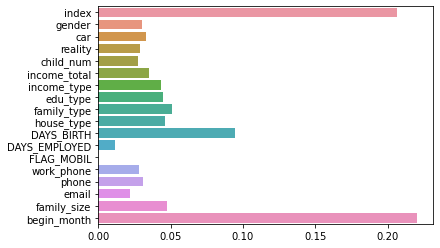

In [75]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(clf.feature_importances_, y=feature_names)

In [30]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.8508510800735897
FOLD 1 : logloss:0.8488090912324694
FOLD 2 : logloss:0.8497394818279445
FOLD 3 : logloss:0.8475365305229623
FOLD 4 : logloss:0.8457256151627915
Mean:0.8485323597639514


In [392]:
my_submission

(26457, 3)

In [32]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [33]:
submission.loc[:,1:]=my_submission

In [34]:
submission

,index,0,1,2
0,26457,0.118916,0.219820,0.661264
1,26458,0.109289,0.220176,0.670535
2,26459,0.102643,0.249998,0.647359
3,26460,0.131527,0.204577,0.663896
4,26461,0.143888,0.323971,0.532140
...,...,...,...,...
9995,36452,0.110772,0.267286,0.621942
9996,36453,0.094696,0.327186,0.578118
9997,36454,0.108017,0.196897,0.695085
9998,36455,0.120710,0.247378,0.631912


In [36]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_rf.csv', index=False)

### 2. AdaBoost

In [76]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
ada_clf= AdaBoostClassifier(random_state = 10, n_estimators = 10) 
ada_clf.fit(X_train, y_train)
y_pred=ada_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(ada_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ada_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.641
테스트 세트 정확도: 0.641
log_loss: 1.0523664981586929


<AxesSubplot:>

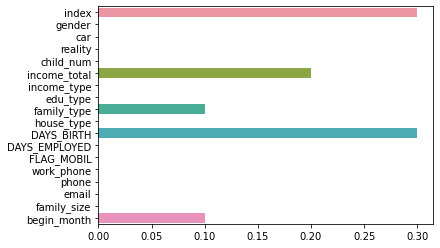

In [77]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(ada_clf.feature_importances_, y=feature_names)

In [78]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(ada_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        ada_clf.fit(X_train, y_train)
        
        predictions=ada_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=ada_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(ada_clf)

FOLD 0 : logloss:1.0525183950848656
FOLD 1 : logloss:1.0521019669592764
FOLD 2 : logloss:1.052028698077584
FOLD 3 : logloss:1.05471162757762
FOLD 4 : logloss:1.0522401565514188
Mean:1.052720168850153


In [79]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_ada.csv', index=False)

### 3. GBM

In [80]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
gb_clf=GradientBoostingClassifier(max_depth = 6, n_estimators = 700 ,learning_rate = 0.01)
gb_clf.fit(X_train, y_train)
y_pred=gb_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(gb_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gb_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.676
테스트 세트 정확도: 0.640
log_loss: 0.8594515834778458


<AxesSubplot:>

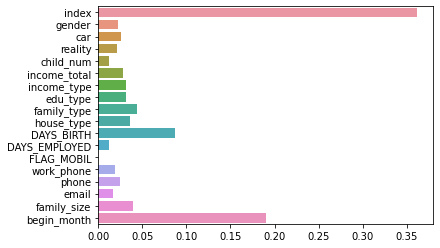

In [81]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(gb_clf.feature_importances_, y=feature_names)

In [82]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(gb_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        gb_clf.fit(X_train, y_train)
        
        predictions=gb_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=gb_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(gb_clf)

FOLD 0 : logloss:0.8591750366251788
FOLD 1 : logloss:0.8597680603979402
FOLD 2 : logloss:0.8581145215201603
FOLD 3 : logloss:0.8610761353677229
FOLD 4 : logloss:0.8588016115777816
Mean:0.8593870730977567


In [83]:
submission.loc[:,1:]=my_submission

In [84]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_gb.csv', index=False)

### 4. XGBoost

In [86]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
xgb_clf=XGBClassifier(n_estimators = 100, learning_rate = 0.1)
xgb_clf.fit(X_train, y_train)
y_pred=xgb_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(xgb_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(xgb_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

[01:49:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
훈련 세트 정확도: 0.667
테스트 세트 정확도: 0.639
log_loss: 0.8599134544790557


<AxesSubplot:>

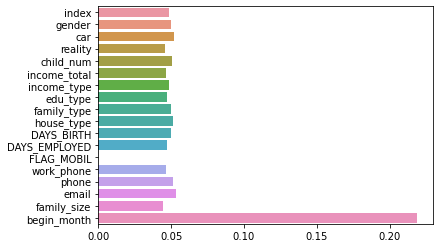

In [87]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(xgb_clf.feature_importances_, y=feature_names)

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(xgb_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        xgb_clf.fit(X_train, y_train)
        
        predictions=xgb_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=xgb_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(xgb_clf)

[01:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD 0 : logloss:0.8577801340955816
[01:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD 1 : logloss:0.8574832625298543
[01:40:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behav

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_xgb.csv', index=False)

### 5. CATboost

- get_dummies

In [55]:
'''train_x = pd.get_dummies(train_x, drop_first=True)
test_x = pd.get_dummies(test_x, drop_first=True)'''

In [ ]:
'''# 특성 중요도 시각화
import seaborn as sns
plt.figure(figsize=(10,10))
feature_names = list(train_x.columns)
sns.barplot(cat_clf.feature_importances_, y=feature_names)'''

In [ ]:
''''from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)''''

In [ ]:
# submission.loc[:,1:]=my_submission

In [ ]:
# submission.to_csv('C:/Users/qorwl/Documents/credit_project/data/baseline_submission_cat_onehot.csv', index=False)

- ordinal

In [177]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

train_x = ordinal_encoder.fit_transform(train_x.values.tolist())
train_x.shape

test_x = ordinal_encoder.fit_transform(test_x.values.tolist())
test_x.shape


(10000, 16)

In [178]:
train_x = pd.DataFrame(train_x, columns=[['gender','car','reality','child_num','income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','begin_month']])
test_x = pd.DataFrame(test_x, columns=[['gender','car','reality','child_num','income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','begin_month']])

In [180]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,3.0,0.0,4.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0
2,1.0,1.0,1.0,0.0,3.0,4.0,1.0,1.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,2.0,0.0,4.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,2.0
4,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.0,0.0,0.0,2.0,2.0,2.0,4.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,3.0,0.0
26453,0.0,0.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0
26454,0.0,1.0,0.0,0.0,3.0,4.0,4.0,0.0,5.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0
26455,1.0,0.0,1.0,0.0,2.0,4.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0


In [179]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0552625	total: 5.85ms	remaining: 5.84s
1:	learn: 1.0208445	total: 12ms	remaining: 6.01s
2:	learn: 0.9929865	total: 16.4ms	remaining: 5.45s
3:	learn: 0.9702706	total: 20.6ms	remaining: 5.14s
4:	learn: 0.9515449	total: 25ms	remaining: 4.97s
5:	learn: 0.9360123	total: 29.2ms	remaining: 4.83s
6:	learn: 0.9230173	total: 34.2ms	remaining: 4.85s
7:	learn: 0.9122896	total: 38.8ms	remaining: 4.81s
8:	learn: 0.9028600	total: 43.5ms	remaining: 4.79s
9:	learn: 0.8951890	total: 47.9ms	remaining: 4.74s
10:	learn: 0.8887617	total: 52.6ms	remaining: 4.73s
11:	learn: 0.8834729	total: 56.5ms	remaining: 4.65s
12:	learn: 0.8788194	total: 60.8ms	remaining: 4.62s
13:	learn: 0.8747824	total: 66.2ms	remaining: 4.66s
14:	learn: 0.8715186	total: 71.2ms	remaining: 4.68s
15:	learn: 0.8684417	total: 75.4ms	remaining: 4.63s
16:	learn: 0.8658549	total: 79.7ms	remaining: 4.61s
17:	learn: 0.8635976	total: 84.1ms	remaining: 4.59s
18:	learn: 0.8616260	total: 88.4ms	remaining: 4.

In [182]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0549201	total: 5.67ms	remaining: 5.66s
1:	learn: 1.0202549	total: 11.6ms	remaining: 5.77s
2:	learn: 0.9921548	total: 15.5ms	remaining: 5.17s
3:	learn: 0.9693510	total: 19.9ms	remaining: 4.95s
4:	learn: 0.9505719	total: 25.4ms	remaining: 5.05s
5:	learn: 0.9348896	total: 29.9ms	remaining: 4.95s
6:	learn: 0.9218800	total: 34.7ms	remaining: 4.92s
7:	learn: 0.9110463	total: 40.3ms	remaining: 4.99s
8:	learn: 0.9017140	total: 45ms	remaining: 4.95s
9:	learn: 0.8940732	total: 50.3ms	remaining: 4.98s
10:	learn: 0.8878541	total: 55.3ms	remaining: 4.97s
11:	learn: 0.8823656	total: 66.1ms	remaining: 5.44s
12:	learn: 0.8777317	total: 70.9ms	remaining: 5.38s
13:	learn: 0.8735605	total: 75.8ms	remaining: 5.34s
14:	learn: 0.8701373	total: 80.1ms	remaining: 5.26s
15:	learn: 0.8671195	total: 84.4ms	remaining: 5.19s
16:	learn: 0.8646711	total: 89.1ms	remaining: 5.15s
17:	learn: 0.8623035	total: 93.7ms	remaining: 5.11s
18:	learn: 0.8603379	total: 98.1ms	remaining: 

In [190]:
import graphviz
cat_clf.plot_tree(tree_idx = 0)

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [409]:
my_submission.shape

(10000, 3)

In [410]:
submission.loc[:,1:]=my_submission

In [411]:
submission.to_csv('C:/Users/qorwl/Documents/credit_project/data/baseline_submission_cat_ord.csv', index=False)

### 6. LGBM

- get_dummies

In [59]:
train_x = pd.get_dummies(train_x, drop_first=True)
test_x = pd.get_dummies(test_x, drop_first=True)

In [60]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
lgbm_clf=LGBMClassifier(n_estimators = 100, learning_rate = 0.1)
lgbm_clf.fit(X_train, y_train)
y_pred=lgbm_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(lgbm_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lgbm_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.676
테스트 세트 정확도: 0.653
log_loss: 0.8294716294308895


In [61]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(lgbm_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        lgbm_clf.fit(X_train, y_train)
        
        predictions=lgbm_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=lgbm_clf.predict_proba(test_x)
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(lgbm_clf)

FOLD 0 : logloss:0.8339878657391622
FOLD 1 : logloss:0.8276205380809266
FOLD 2 : logloss:0.8283706849892946
FOLD 3 : logloss:0.8287016983414061
FOLD 4 : logloss:0.829336693197789
Mean:0.8296034960697156


- ordinal 

In [114]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

train_x = ordinal_encoder.fit_transform(train_x.values.tolist())
train_x.shape

test_x = ordinal_encoder.fit_transform(test_x.values.tolist())
test_x.shape

(10000, 16)

In [115]:
train_x = pd.DataFrame(train_x, columns=[['gender','car','reality','child_num','income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','begin_month']])
test_x = pd.DataFrame(test_x, columns=[['gender','car','reality','child_num','income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','begin_month']])

In [117]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,3.0,0.0,4.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0
2,1.0,1.0,1.0,0.0,3.0,4.0,1.0,1.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,2.0,0.0,4.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,2.0
4,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.0,0.0,0.0,2.0,2.0,2.0,4.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,3.0,0.0
26453,0.0,0.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0
26454,0.0,1.0,0.0,0.0,3.0,4.0,4.0,0.0,5.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0
26455,1.0,0.0,1.0,0.0,2.0,4.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0


In [120]:
type(y_train)

pandas.core.frame.DataFrame

In [118]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
lgbm_clf=LGBMClassifier(n_estimators = 100, learning_rate = 0.1)
lgbm_clf.fit(X_train, y_train)
y_pred=lgbm_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(lgbm_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lgbm_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

AttributeError: 'tuple' object has no attribute 'encode'